In [352]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline 


In [210]:
booze = pd.read_csv('../iowa_liquor_sales_proj_2.csv')
booze.shape

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2709552, 24)

In [211]:
#Finding patterns for store location
import re
#tester = booze.head()
# tester
# pattern2 = r'[(].+[)]'
# tester['Store Location'].apply(lambda x: re.findall(pattern2,x))

In [212]:
booze.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S29198800001,11/20/2015,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,6,$162.84,4.50,1.19
1,S29195400002,11/21/2015,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,12,$325.68,9.00,2.38
2,S29050300001,11/16/2015,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08
3,S28867700001,11/04/2015,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,...,237,Knob Creek w/ Crystal Decanter,3,1750,$35.55,$53.34,3,$160.02,5.25,1.39
4,S29050800001,11/17/2015,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08


In [213]:
#Converting date column to datetime format
booze['Date'] = pd.to_datetime(booze['Date'], infer_datetime_format=True)

In [214]:
#Cleaning columns to be numeric
booze['Sale (Dollars)'] = booze['Sale (Dollars)'].str.replace('$', '').astype(float)
booze['State Bottle Retail'] = booze['State Bottle Retail'].str.replace('$', '').astype(float)
booze['State Bottle Cost'] = booze['State Bottle Cost'].str.replace('$', '').astype(float)

In [215]:
#Turning non-numeric numeric columns into objects 
booze['Category'] = booze['Category'].astype(object)
booze['Vendor Number'] = booze['Vendor Number'].astype(object)
booze['Item Number'] = booze['Item Number'].astype(object)
booze['County Number'] = booze['County Number'].astype(object)
booze['Store Number'] = booze['Store Number'].astype(object)

In [216]:
#Selecting only the numeric columns
numeric_columns = []
for col in booze.columns:
    if isinstance(booze[col][0], (np.float64, np.int64)):
        numeric_columns.append(col)

In [217]:
#creating subframe to identify  outliers, standardizing
mask = booze[numeric_columns]
standard_mask = StandardScaler()
mask = pd.DataFrame(standard_mask.fit_transform(mask), columns=numeric_columns)

In [218]:
#LOCATING OUTLIERS and DROPPING THEM
index_list = []

for col in mask.columns: 
    df = mask.loc[(mask[col] > 6) | (mask[col] < -6)]
    index_list.extend(list(df.index))

index_list = list(set(index_list))

todrop = mask.iloc[index_list]

#Exploring outliers- the outliers seem well dispersed between cities
booze.iloc[index_list].groupby('City')[['Store Number']].nunique()
#The types of liquors prevalent in the subgroup are also dispersed between brand types 
booze.iloc[index_list].groupby('Item Description')[['Store Number']].nunique().sort_values(by='Store Number', ascending=False)

#Will run with and without these outliers, creating subset with outliers removed,
#dropped observations represent less than 0.5% of observations and are more than 6 standard
#deviations from the mean
booze_cleaned = booze.drop(todrop.index)
mask = mask.drop(todrop.index)

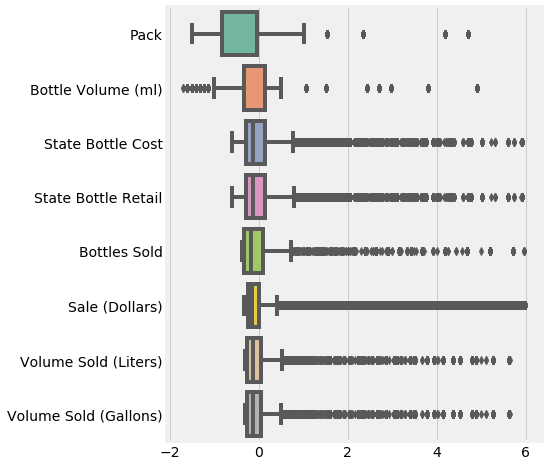

In [219]:
#Looking at distributions
#The outliers from pack size appear to be reasonable
#the fireball mini dispenser comprises 92% of the bottle volume outliers above 2 stds. This is ok. 
#Most outliers explained by the peculiarity of brand or the purpose of store (primarily liquor store/not liquor store)
#USE two lines of code below code to explore further, replacing column as aprpriorate
#list_pack = list(mask.loc[mask['Bottles Sold'] > 3].index)
# booze.iloc[list_pack]
fig = plt.figure(figsize=(6, 8))
plt.style.use('fivethirtyeight')
ax = sns.boxplot(data=mask, orient="h", palette="Set2")

In [220]:
#Splitting between 2015 and 2016
mask_dates = (booze_cleaned['Date'] > '12/31/2014') & (booze_cleaned['Date'] < '1/1/2016')
booze_2015 = booze_cleaned.loc[mask_dates]
mask_dates2 = (booze_cleaned['Date'] > '12/31/2015')
booze_2016 = booze_cleaned.loc[mask_dates2]

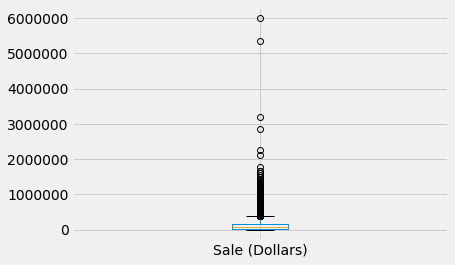

In [221]:
#Creating my 2015 target variable, and examining dispersion of sales data
target = booze_2015.groupby('Store Number')[['Sale (Dollars)']].sum()
target.plot.box()

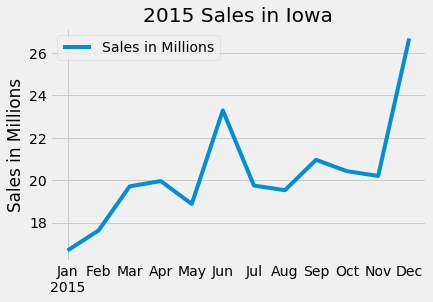

In [222]:
#Creating a chart for monthly total sales in Iowa 2015
booze_2015_charts = booze_2015.copy()
booze_2015_charts = booze_2015_charts.set_index('Date').resample('M')[['Sale (Dollars)']].sum()
booze_2015_charts['Sales in Millions'] = booze_2015_charts['Sale (Dollars)'] / 1000000
booze_2015_charts['Sales in Millions'].plot()
plt.legend()
plt.ylabel('Sales in Millions')
plt.xlabel('')
plt.title('2015 Sales in Iowa')
plt.show()

In [223]:
X_booze = booze_2015.groupby('Store Number')[['State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Gallons)']].sum().reset_index(level=0)

In [224]:
#Merging demographic details with X_booze
x_county = booze_2015.drop_duplicates(subset=['Store Number', 'County'])

#Removing duplicate county (because of NaN value)
mask3 = x_county[x_county['Store Number'].duplicated(keep=False)]
x_county = x_county[['County', 'Store Number']].drop([469])

#Merge beginning
x_first = pd.merge(X_booze, x_county, on='Store Number')

#Cleaning county demographics
county_demographics = pd.read_csv('../IowaDemographics.csv',index_col=0)
county_demographics['Areaname'] = county_demographics['Areaname'].str.split(',', expand=True)
county_demographics = county_demographics.drop('Median household income 2005', axis=1)
county_demographics['Median household income 2009 (thousands)']= county_demographics['Median household income 2009'] / 1000

#Merging
X = pd.merge(x_first, county_demographics, left_on='County', right_on='Areaname')
X = X.drop('Areaname', axis = 1)
X = X.drop('Sale (Dollars)', axis=1)


In [225]:
#Creating first three months variable
mask_dates_two = (booze_2015['Date'] > '12/31/2014') & (booze_2015['Date'] < '4/1/2015')
three_months = booze_2015[mask_dates_two]
three_months = three_months.groupby('Store Number')['Sale (Dollars)'].sum().reset_index(level=0)

#91 stores didn't have sales in the first three months of 2015
missing_stores = list(set(X['Store Number']) - set(three_months['Store Number']))
monthly_sales_missing = booze_2015[booze_2015['Store Number'].isin(missing_stores)].set_index(['Date']).resample('M')['Sale (Dollars)'].sum()

In [226]:
#Taking the average sales  from the worst month (January) and extrapolating (conservatively) on that
# 16684491 / (1373 - 91)
missing_stores_sim = pd.DataFrame({'Store Number': missing_stores, 'Three months (thousands)': (13014 * 3)/1000})
three_months = three_months.rename(index=str, columns={'Store Number': 'Store Number',
                                                      'Sale (Dollars)': 'Three months (thousands)'})
three_months['Three months (thousands)'] = three_months['Three months (thousands)'] / 1000

In [227]:
#appending missing stores to three month variable
three_month_sales = three_months.append(missing_stores_sim).reset_index(drop=True)

#merging three month variable to X 
X = pd.merge(X, three_month_sales, on='Store Number')

In [228]:
#Creating full first three months data set/ignoring full 2015 data for now... 
three_months_full = booze_2015[mask_dates_two]
three_months_full = three_months_full.groupby('Store Number')[['State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Gallons)']].sum().reset_index(level=0)
three_months_full.head()

,Store Number,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons)
0,2106,12739.50,19125.22,21793,313463.43,5369.95
1,2113,3558.75,5342.48,1618,22351.86,423.73
2,2130,9574.79,14370.92,16123,238893.70,3863.08
3,2152,2954.28,4440.29,1375,16805.11,373.65
4,2178,5160.06,7753.66,4279,54411.42,1156.12


In [229]:
#Imputing missing values based on Xth percentile (changing regularly)
for col in three_months_full.columns: 
    print(col)
    print(three_months_full[col].quantile(.10))

Store Number
2637.4
State Bottle Cost
349.0160000000001
State Bottle Retail
524.623
Bottles Sold
468.0
Sale (Dollars)
4992.872999999999
Volume Sold (Gallons)
94.94000000000001


In [230]:
missing_stores_sim = missing_stores_sim.drop('Three months (thousands)', axis=1)

In [231]:
#Placing missing values into new data frame
nums = [349.0160000000001,  524.623,  468.0 , 4992.872999999999, 94.94000000000001]
for ind, col in enumerate(['State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold','Sale (Dollars)', 'Volume Sold (Gallons)']):
    missing_stores_sim[col] = nums[ind]

#Appending missing stores 
three_months_full = three_months_full.append(missing_stores_sim).reset_index(drop=True)

In [232]:
#Cleaning before appending
three_months_full['Three months (thousands)'] = three_months_full['Sale (Dollars)'] / 1000
three_months_full = three_months_full.drop('Sale (Dollars)', axis = 1)


In [237]:
#Creting new three month frame / merging county data 
X_three = pd.merge(three_months_full, x_county, on='Store Number')

In [238]:
X_three = pd.merge(X_three, county_demographics, left_on='County', right_on='Areaname')
X_three = X_three.drop('Median household income 2009', axis=1)
X_three = X_three.drop('Areaname', axis=1)

In [239]:
#First regression 
X_three = X_three.sort_values('Store Number').set_index('Store Number')
X = X_three[['Bottles Sold', 'State Bottle Cost', 'State Bottle Retail',
        'Three months (thousands)', 'Volume Sold (Gallons)',
        'All People in poverty- 2009', 
       'Percent Population Male 20 - 34 (2016)', 'Population per sq mile',
       'Median household income 2009 (thousands)']]

In [315]:
target['Sale (Dollars)'].sum()

243644726.83000049

In [240]:
X = sm.add_constant(X)
modelOLS = sm.OLS(target, X).fit()
modelOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Sale (Dollars)   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     6793.
Date:                Thu, 08 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:37:28   Log-Likelihood:                -16858.
No. Observations:                1373   AIC:                         3.374e+04
Df Residuals:                    1363   BIC:                         3.379e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                    -1.343e+04   1.55e+04     -0.869      0.385   -4.38e+04    1.69e+04
Bottles Sold                                -6.1133      1.728     -3.538      0.000      -9.503      -2.724
State Bottle Cost                        -1435.9780    646.133     -2.222      0.026   -2703.500    -168.456
State Bottle Retail                        957.7958    430.148      2.227      0.026     113.971    1801.621
Three months (thousands)                  4429.4718    177.889     24.900      0.000    4080.506    4778.438
Volume Sold (Gallons)                       10.8124     11.132      0.971      0.332     -11.026      32.651
All People in poverty- 2009                  0.6573      0.748      0.879      0.379      -0.809       2.124
Percent Population Male 20 - 34 (2016)     -66.1292    442.090     -0.150      0.881    -933.380     801.122
Population per sq mile                     -22.9636     45.117     -0.509      0.611    -111.471      65.544
Median household income 2009 (thousands)   302.1727    310.893      0.972      0.331    -307.708     912.054
==============================================================================
Omnibus:                      929.997   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83614.528
Skew:                           2.333   Prob(JB):                         0.00
Kurtosis:                      40.945   Cond. No.                     2.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [349]:
#Completely reduced model
X = X_three[[
        'Three months (thousands)']]
X = sm.add_constant(X)
modelOLS = sm.OLS(target, X).fit()
modelOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Sale (Dollars)   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 5.920e+04
Date:                Thu, 08 Feb 2018   Prob (F-statistic):               0.00
Time:                        19:56:45   Log-Likelihood:                -16884.
No. Observations:                1373   AIC:                         3.377e+04
Df Residuals:                    1371   BIC:                         3.378e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     5005.7644   1597.224      3.134      0.002    1872.496    8139.033
Three months (thousands)  4346.4395     17.864    243.306      0.000    4311.396    4381.483
==============================================================================
Omnibus:                      953.875   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77816.106
Skew:                           2.464   Prob(JB):                         0.00
Kurtosis:                      39.550   Cond. No.                         99.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[]

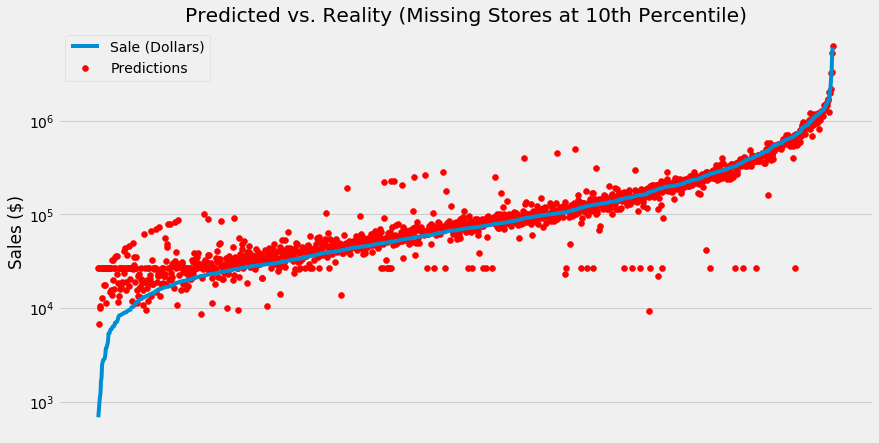

In [243]:
#Graphing store by store residuals
predictions = modelOLS.predict(X)
base_model = list(predictions)
new_targ = target.copy()
new_targ['Predictions'] = base_model
new_targ = new_targ.sort_values('Sale (Dollars)')

#Figure
fig = plt.figure(figsize=(13,7))
ax = fig.gca()
plt.plot(np.arange(0, 1373), new_targ['Sale (Dollars)'])
plt.scatter(np.arange(0, 1373), new_targ['Predictions'], c='Red')
plt.legend()
plt.ylabel('Sales ($)')
plt.title('Predicted vs. Reality (Missing Stores at 10th Percentile)')
ax.set_yscale('log')
ax.get_xaxis().set_ticks([])

In [265]:
#Prepping 2016 for analysis 
three_2016 = booze_2016.groupby('Store Number', as_index=False)[['Sale (Dollars)']].sum()
three_2016['Three months (thousands) 2016'] = three_2016['Sale (Dollars)'] / 1000
three_2016 = three_2016.drop('Sale (Dollars)', axis=1)

In [289]:
#I am going to assume that the new year will have a similar number of stores without sales in the first three months,
#and that they follow a similar sales pattern (10th percentile)
#set(X_three.reset_index()['Store Number']) - set(three_2016['Store Number']) ... looking at non-overlapping values
merged_comparison = pd.merge(three_2016, X_three.reset_index()[['Store Number', 'Three months (thousands)']], on='Store Number')

In [321]:
merged_comparison['difference'] = merged_comparison['Three months (thousands) 2016'] - merged_comparison['Three months (thousands)']
# matched stores on average sold 2900 more in 2016, ~3.8 million more in total
mask = merged_comparison.duplicated(subset='Three months (thousands)')
#however there were 84 stores that were given artificial data for 2015, with 18,000 additional sales in 2016
merged_comparison[mask]['difference'].mean()
#removing these leads to only 1800 in additional sales.
merged_comparison[~mask]['difference'].mean()
X = merged_comparison[['Three months (thousands) 2016']]

In [322]:
#2016 basic predictions
X = sm.add_constant(X)
predictions = modelOLS.predict(X)
sum(predictions)

251684402.3431237

In [345]:
target['Sale (Dollars)'].quantile(.10)

17474.480000000003

In [333]:
merged_comparison['2016 predictions'] = predictions
merge_2 = pd.merge(merged_comparison, target.reset_index(), on='Store Number')
merge_2 = merge_2[['2016 predictions', 'Sale (Dollars)']].sort_values('Sale (Dollars)')
merge_2.shape

(1290, 2)

[]

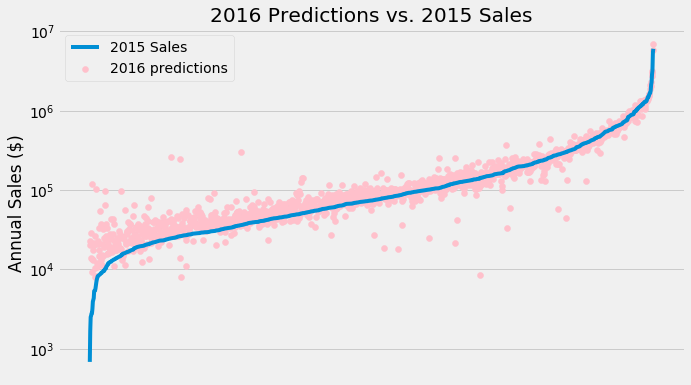

In [343]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
plt.plot(np.arange(0,1290), merge_2['Sale (Dollars)'], label='2015 Sales')
plt.scatter(np.arange(0, 1290), merge_2['2016 predictions'], c='pink')
plt.legend()
plt.ylabel('Annual Sales ($)')
plt.title('2016 Predictions vs. 2015 Sales')
ax.set_yscale('log')
ax.get_xaxis().set_ticks([])

In [348]:
#Assuming similar number of store will record sales in 2016, that didn't in first three months
#specifically, conservatively assuming 60% fo the 91 that did the previous year...
target['Sale (Dollars)'].quantile(.10) * 91
(251.7 + 1.6)/243.6

1.0398193760262726

In [354]:
#Now messing with a little cross-val training 
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.5, random_state=48)

In [356]:
modelOLS = sm.OLS(y_train, X_train).fit()
modelOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Sale (Dollars)   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 3.327e+04
Date:                Thu, 08 Feb 2018   Prob (F-statistic):               0.00
Time:                        20:05:58   Log-Likelihood:                -8423.4
No. Observations:                 686   AIC:                         1.685e+04
Df Residuals:                     684   BIC:                         1.686e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     4703.2503   2219.973      2.119      0.034     344.470    9062.031
Three months (thousands)  4386.1231     24.046    182.407      0.000    4338.911    4433.335
==============================================================================
Omnibus:                      434.368   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17131.096
Skew:                           2.223   Prob(JB):                         0.00
Kurtosis:                      27.074   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""